In [1]:
## Import libraries, set random seed for reproducibility, and define device and parameters
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from camflow import OpticalFilter, ADC, Demosaic
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cpu")
# Parameters
H, W = 800, 800
C = 31  # spectral channels

# Inverse Engineering 1: Optical Filter Recovery

(1) Init + Training

In [2]:
# Inverse Engineering 1: Optical Filter Recovery
# Ground-truth filter: Gaussian-shaped already defined in OpticalFilter init, but let's define our own GT here
start_wl, end_wl = 400, 700
wavelengths = torch.linspace(start_wl, end_wl, C)
gt_mean, gt_std = 550.0, 100.0
gt_filter = torch.exp(-0.5 * ((wavelengths - gt_mean) / gt_std)**2)
gt_filter = gt_filter / gt_filter.max()

# Generate random scene spectral radiance [H,W,C]
scene_radiance = torch.rand(H, W, C) # U(0,1)

# Apply GT filter
filtered_scene = scene_radiance * gt_filter  # element-wise
filtered_scene = filtered_scene.unsqueeze(0) # [1,H,W,C]

# We will start from a U(0,1) random OpticalFilter and try to recover gt_filter
optical_model = OpticalFilter(num_channels=C).to(device)
# Overwrite initial filter with random init
with torch.no_grad():
    optical_model.filter.data = torch.rand(C)

opt = optim.Adam(optical_model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=1000)

init_filter = optical_model.filter.detach().clone()
# In[3]:
# Train optical filter recovery
num_iters = 200
losses_optical = []
for i in range(num_iters):
    opt.zero_grad()
    pred = optical_model(scene_radiance.unsqueeze(0))
    loss = ((pred - filtered_scene)**2).mean()
    loss.backward()
    opt.step()
    scheduler.step()
    losses_optical.append(loss.item())
    if (i+1) % 50 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item():.6f}")


Iteration 50, Loss: 0.000119
Iteration 100, Loss: 0.000000
Iteration 150, Loss: 0.000000
Iteration 200, Loss: 0.000000


(2) Plot Training Curve and Filters.

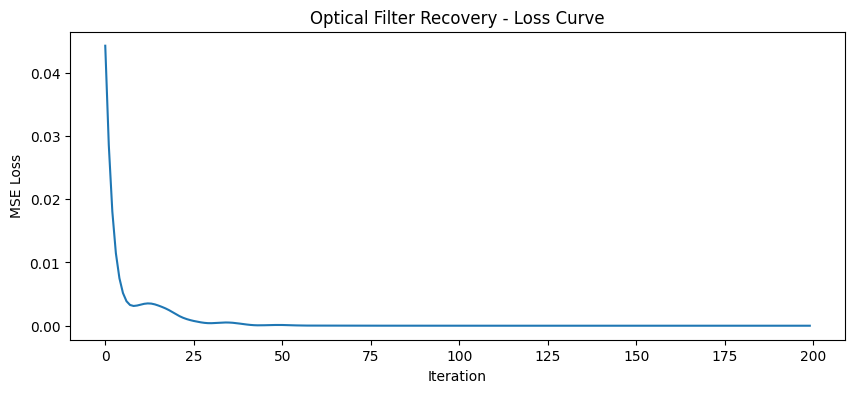

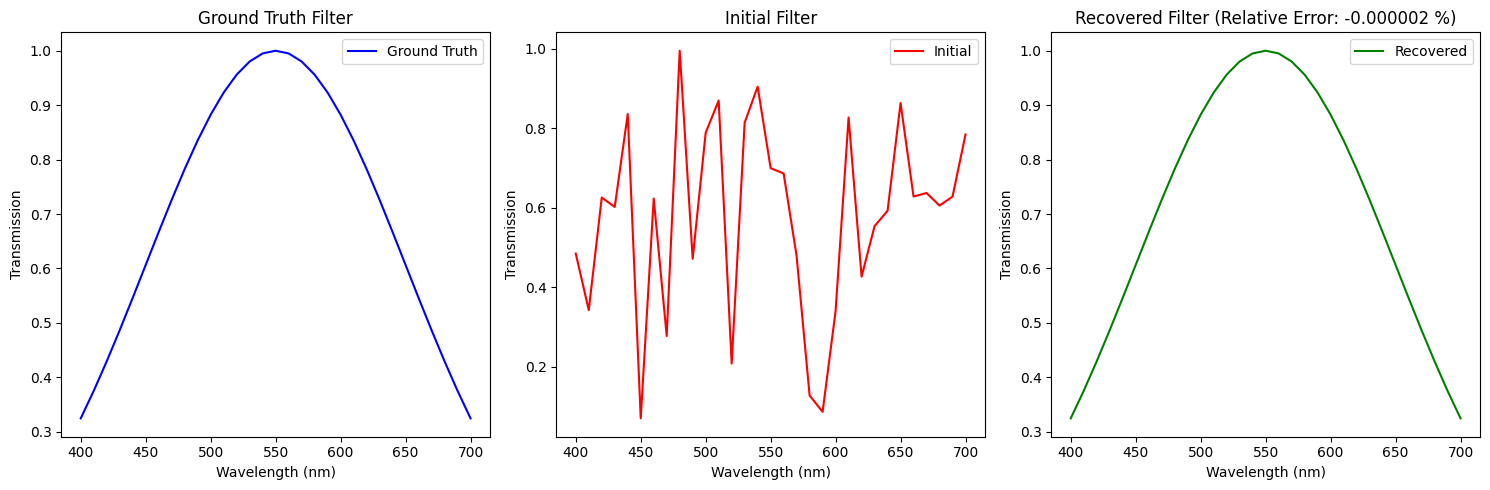

In [3]:
# Plot results for Optical Filter
plt.figure(figsize=(10,4))
plt.subplot(1,1,1)
plt.plot(losses_optical)
plt.title("Optical Filter Recovery - Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")


# Plot results for Optical Filter
plt.figure(figsize=(15, 5))

# Ground Truth Filter
plt.subplot(1, 3, 1)
plt.plot(wavelengths, gt_filter.detach().numpy(), label='Ground Truth', color='blue')
plt.title("Ground Truth Filter")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend()

# Recovered Filter
rel_error = torch.sum(gt_filter - optical_model.filter) / torch.sum(gt_filter)
plt.subplot(1, 3, 3)
plt.plot(wavelengths, optical_model.filter.detach().numpy(), label='Recovered', color='green')
plt.title(f"Recovered Filter (Relative Error: {rel_error:.6f} %)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend()

# Initial Filter
plt.subplot(1, 3, 2)
plt.plot(wavelengths, init_filter.numpy(), label='Initial', color='red')
plt.title("Initial Filter")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
plt.legend()

plt.tight_layout()
plt.show()


# Inverse Engineering 2: ADC Quantization Step Retrieval

(1) Init + Training

In [ ]:
# Ground-truth step size = 0.1, input = random image in [0,1]
gt_step_size = 0.1
adc_input = torch.rand(1, H, W)
quantized = torch.floor(adc_input / gt_step_size) 
num_iters = 200
adc_model = ADC(init_step=0.5).to(device)
opt = optim.Adam(adc_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_iters)

# print(f"Ground-truth step size: {gt_step_size}")
# print(f"Input: {adc_input.squeeze().detach().numpy()}")
# print(f"Quantized: {quantized.squeeze().detach().numpy()}")

losses_adc = []
for i in range(num_iters):
    opt.zero_grad()
    pred = adc_model(adc_input)
    loss = ((pred - quantized)**2).mean()
    loss.backward()
    opt.step()
    scheduler.step()
    losses_adc.append(loss.item())

    # # print pred
    # if (i+1) % 200 == 0:
    #     print(f"pred = {pred.squeeze().detach().numpy()}")

    # # print gradient of step size
    # if (i+1) % 200 == 0:
    #     print(f"grad step size: {adc_model.step_size._grad.item()}")
    if (i+1) % 50 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item():.6f}, Step size: {adc_model.step_size.item():.4f}")


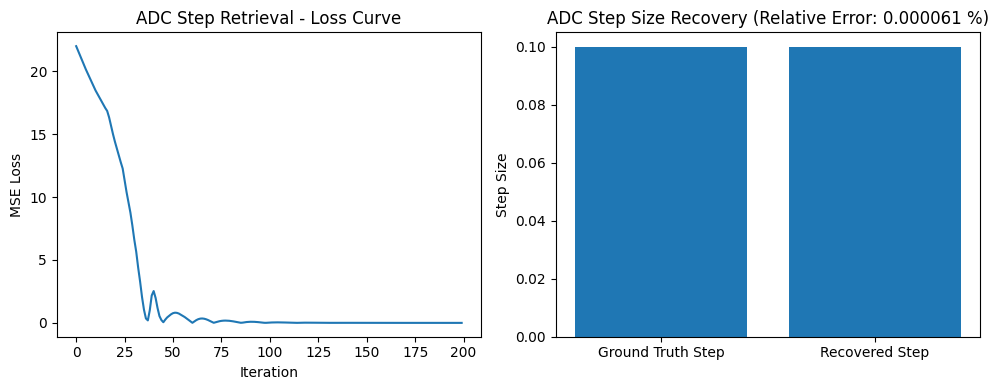

In [12]:
# Plot results for ADC Retrieval
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses_adc)
plt.title("ADC Step Retrieval - Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")

# COMPUTE RELATIVE ERROR
rel_error = (gt_step_size - adc_model.step_size.item()) / gt_step_size

plt.subplot(1,2,2)
plt.bar(['Ground Truth Step', 'Recovered Step'], [gt_step_size, adc_model.step_size.item()])
plt.title(f"ADC Step Size Recovery (Relative Error: {rel_error:.6f} %)")
plt.ylabel("Step Size")
plt.tight_layout()
plt.show()

# Inverse Engineering 3: Demosaicing Kernel Inversion

In [15]:
# Ground truth demosaic kernels:
# R: pick upper-left pixel
# G: avg upper-right and bottom-left
# B: pick bottom-right
# Already defined in the Demosaic class. Let's create a GT model and input.

demosaic_gt = Demosaic().to(device)
# Freeze GT model
for p in demosaic_gt.parameters():
    p.requires_grad = False

mosaic_input = torch.rand(1, H, W)

# Get GT output
with torch.no_grad():
    demosaic_gt_out = demosaic_gt(mosaic_input)

# Now create a new demosaic model from scratch and try to recover kernels
demosaic_model = Demosaic().to(device)
# Initialize with random weights
with torch.no_grad():
    demosaic_model.kernel.data = torch.randn_like(demosaic_model.kernel.data)

opt = optim.Adam(demosaic_model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=1000)

losses_demosaic = []
for i in range(1000):
    opt.zero_grad()
    pred = demosaic_model(mosaic_input)
    loss = ((pred - demosaic_gt_out)**2).mean()
    loss.backward()
    opt.step()
    scheduler.step()
    losses_demosaic.append(loss.item())
    if (i+1) % 200 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item():.6f}")


Iteration 200, Loss: 0.000031
Iteration 400, Loss: 0.000000
Iteration 600, Loss: 0.000000
Iteration 800, Loss: 0.000000
Iteration 1000, Loss: 0.000000


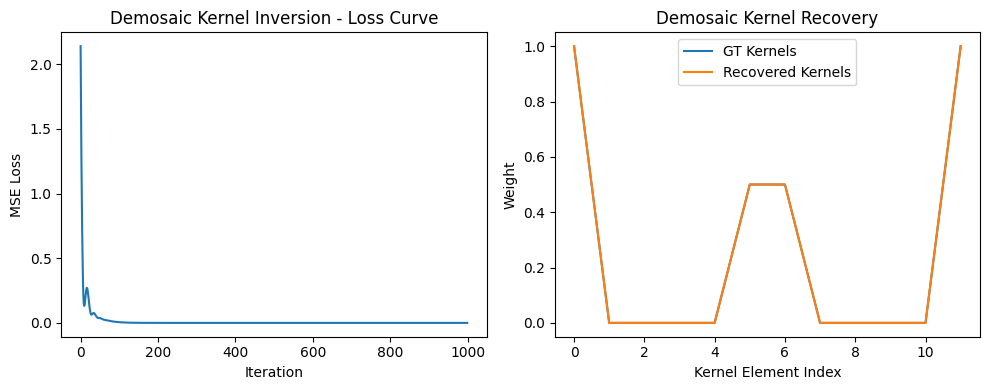

In [16]:
# Plot results for Demosaic Kernel Inversion
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses_demosaic)
plt.title("Demosaic Kernel Inversion - Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")

# Compare kernels
gt_kernel = demosaic_gt.kernel.detach().numpy().squeeze()
rec_kernel = demosaic_model.kernel.detach().numpy().squeeze()

plt.subplot(1,2,2)
plt.plot(gt_kernel.flatten(), label='GT Kernels')
plt.plot(rec_kernel.flatten(), label='Recovered Kernels')
plt.title("Demosaic Kernel Recovery")
plt.xlabel("Kernel Element Index")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()